In [1]:
%matplotlib notebook
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU.')
else:
    device = torch.device('cpu')
    print('Running on the CPU.')

Running on the GPU.


## Data generation

In [3]:
vector_length = 5
models_variance = 1.0
segments_length = 200
segments_variance = 5.0

speakers_ids = ['A', 'B', 'C']
speakers_models = [-152.0, 43.0, 898.0]
speakers_models = [np.random.normal(speakers_models[i], models_variance, vector_length) for i, speaker_id in enumerate(speakers_ids)]

speakers = {}
for i, speaker_id in enumerate(speakers_ids):
    speakers[speaker_id] = {}
    speakers[speaker_id]['speaker_id'] = speaker_id
    speakers[speaker_id]['models'] = [speakers_models[i]]

segments = []
for i, speaker_id in enumerate(speakers):
    speaker = speakers[speaker_id]
    for j in range(segments_length):
        segments.append({ 'speaker_id': speaker_id, 'vector': np.asarray([np.random.normal(value, segments_variance) for value in speaker['models'][0]]) })


## Data indexation

In [4]:
models_container_length = 3

permutations = list(itertools.permutations(speakers_ids + ['0' for i in range(models_container_length)], models_container_length))
#permutations = list(itertools.permutations(speakers_ids, models_container_length))
permutations = list(set(permutations))
permutations_length = 0
permutations_map = []
for i, permutation in enumerate(permutations):
    permutation_length = int(np.prod([len(speakers[speaker_id]['models']) for speaker_id in permutation if speaker_id in speakers_ids]))
    permutations_map.append((permutations_length, permutations_length + permutation_length - 1, i))
    permutations_length += permutation_length
recording_length = len(segments) * permutations_length

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class Recordings_dataset(Dataset):
    def __len__(self):
        return recording_length
    def __getitem__(self, idx):
        segment_i, permutation_i = divmod(idx, permutations_length)
        segment = segments[segment_i]
        permutation_tuple = list(filter(lambda permutation_tuple: permutation_tuple[0] <= permutation_i and permutation_i <= permutation_tuple[1], permutations_map))[0]
        permutation_i = permutation_tuple[2]
        permutation = permutations[permutation_i]
        vector = segment['vector']
        models_container = [speakers[speaker_id]['models'][0] if speaker_id != '0' else np.zeros(vector_length) for speaker_id in permutation]
        
        x = np.concatenate([vector] + models_container)
        y = np.asarray([speaker_id == segment['speaker_id'] for speaker_id in permutation], dtype = float)
        
        return x, y
        
recordings_dataset = Recordings_dataset()
print(len(recordings_dataset))

train_length = int(len(recordings_dataset) * 0.7)
test_length = len(recordings_dataset) - train_length
cross_length = int(train_length * 0.3)
train_length = train_length - cross_length

train_dataset, cross_dataset, test_dataset = random_split(recordings_dataset, [train_length, cross_length, test_length])
train_dataloader = DataLoader(train_dataset, batch_size = 20, shuffle=True, num_workers = 4)
cross_dataloader = DataLoader(cross_dataset, batch_size = len(cross_dataset), num_workers = 4)

20400


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(4 * vector_length, 6)
        self.fc1 = nn.Linear(6, 6)
        self.fc2 = nn.Linear(6, 6)
        self.fc3 = nn.Linear(6, 3)
    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

<IPython.core.display.Javascript object>


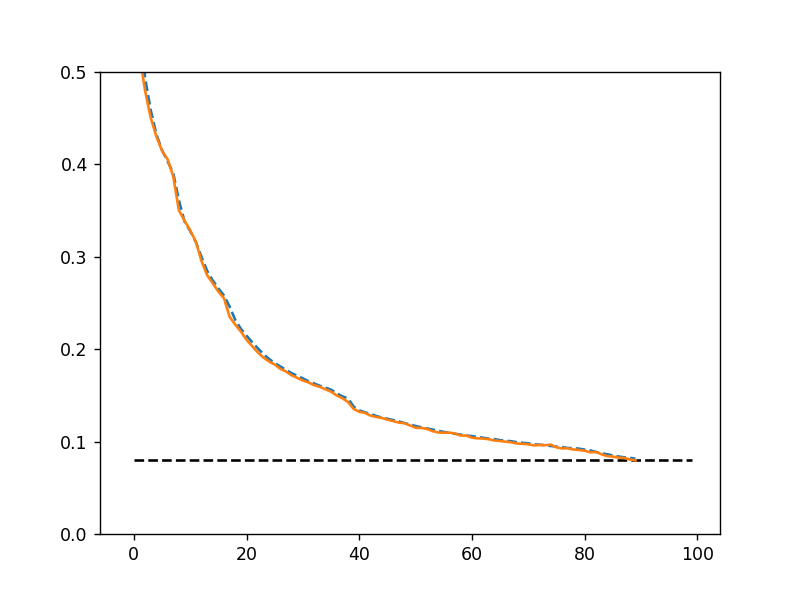

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Done training.


In [7]:
import torch.optim as optim

net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.0001)
criterion = nn.BCELoss()

epochs = 100
cross_loss_thr = 0.08

plt_thr = (np.linspace(0, epochs - 1, epochs), np.ones(epochs) * cross_loss_thr)
plt_loss = ([-1], [1])
plt_valid = ([-1], [1])

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylim(0, 0.5)
line0, = ax.plot(plt_thr[0], plt_thr[1], 'k--')  # Threshold line
line1, = ax.plot(plt_loss[0], plt_loss[1], '--') # Training loss
line2, = ax.plot(plt_valid[0], plt_valid[1])     # Validation loss
fig.canvas.draw()
fig.canvas.flush_events()

for epoch in range(epochs):
    losses = []
    for input, target in train_dataloader:
        input = input.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).float()

        net.zero_grad()

        output = net(input)

        loss = criterion(output, target)
        losses.append(loss.data)

        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for input, target in cross_dataloader:
            input = input.to(device, non_blocking=True).float()
            target = target.to(device, non_blocking=True).float()
            output = net(input)
            cross_loss = criterion(output, target)
            
    plt_loss[0].append(epoch)
    plt_loss[1].append(np.sum(losses) / len(losses))
    plt_valid[0].append(epoch)
    plt_valid[1].append(cross_loss.data)
    line1.set_xdata(plt_loss[0])
    line1.set_ydata(plt_loss[1])
    line2.set_xdata(plt_valid[0])
    line2.set_ydata(plt_valid[1])
    fig.canvas.draw()
    fig.canvas.flush_events()    
        
    # print('epoch:', epoch, 'loss:', loss, 'cross_loss:', cross_loss)
    
    if cross_loss < cross_loss_thr:
        print('Done training.')
        break

In [8]:
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset), num_workers = 4)
with torch.no_grad():
    for input, target in test_dataloader:
        input = input.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).float()
        output = net(input)
        test_loss = criterion(output, target)
    print('test_loss:', test_loss)

test_loss: tensor(0.0823, device='cuda:0')


In [9]:
test_dataloader = DataLoader(test_dataset, batch_size = 1, num_workers = 1)
correct = 0
with torch.no_grad():
    for input, target in test_dataloader:
        input = input.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).float()
        output = net(input)
        if target.max(1)[1] == output.max(1)[1]:
            correct += 1
print(correct / len(test_dataset))

0.6808823529411765
